In [ ]:
!pip install transformers datasets accelerate peft bitsandbytes
!pip install evaluate rouge-score
!pip install Pillow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.4/59.4 MB 12.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 3.7 MB/s eta 0:00:00
  Created wheel for rouge-score: filename=rouge_score-0.1.2-py3-none-any.whl size=24934 sha256=5ca867bed93d1ea21bb197727e454727667ddb87589952ae65b37fa47af24cac
  Stored in directory: /root/.cache/pip/wheels/85/9d/af/01feefbe7d55ef5468796f0c68225b6788e85d9d0a281e7a70
Successfully built rouge-score


In [ ]:
from datasets import load_dataset
from transformers import AutoProcessor, BlipForConditionalGeneration
from torch.utils.data import Dataset, DataLoader
import torch

MODEL_NAME = "Salesforce/blip-image-captioning-base"
processor = AutoProcessor.from_pretrained(MODEL_NAME)
model = BlipForConditionalGeneration.from_pretrained(MODEL_NAME).to("cuda")

print("Loading 'pokemon-blip-captions' dataset subset...")
try:
    raw_dataset = load_dataset("lambdalabs/pokemon-blip-captions", split="train[:100]")
except Exception as e:
    print(f"Error loading main dataset: {e}. Falling back to 'conceptual_captions' subset.")
    raw_dataset = load_dataset("conceptual_captions", split="train[:100]")

raw_dataset = raw_dataset.train_test_split(test_size=0.1, seed=42)

print(f"Loaded {len(raw_dataset['train'])} training examples.")
print(f"Loaded {len(raw_dataset['test'])} evaluation examples.")

Loading 'pokemon-blip-captions' dataset subset...
Error loading main dataset: Dataset 'lambdalabs/pokemon-blip-captions' is a gated dataset on the Hub. You must be authenticated to access it.. Falling back to 'conceptual_captions' subset.
Loaded 90 training examples.
Loaded 10 evaluation examples.


In [ ]:
!pip install requests

import requests
from io import BytesIO
import torch
from PIL import Image

class ImageCaptioningDataset(Dataset):
    def __init__(self, dataset, processor):
        self.dataset = dataset
        self.processor = processor
        self.image_url_key = 'image_url'
        self.caption_key = 'caption'

        if self.image_url_key not in dataset.column_names or self.caption_key not in dataset.column_names:
             raise ValueError("Dataset columns missing confirmed keys ('image_url' and 'caption').")


    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        item = self.dataset[idx]
        image_url = item[self.image_url_key]
        caption = item[self.caption_key]

        try:
            response = requests.get(image_url, timeout=10)
            if response.status_code != 200:
                raise ConnectionError(f"Failed to download image from {image_url}")
            image = Image.open(BytesIO(response.content)).convert("RGB")
        except Exception:
            return self.__getitem__((idx + 1) % len(self.dataset))

        encoding = self.processor(
            images=image,
            text=caption,
            padding="max_length",
            return_tensors="pt"
        )

        encoding = {k: v.squeeze() for k, v in encoding.items()}
        encoding["labels"] = encoding.pop("input_ids")

        return encoding

try:
    train_dataset = ImageCaptioningDataset(raw_dataset['train'], processor)
    eval_dataset = ImageCaptioningDataset(raw_dataset['test'], processor)
except ValueError as e:
    print(f"Error creating dataset: {e}")
    raise

train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=4)
eval_dataloader = DataLoader(eval_dataset, shuffle=False, batch_size=4)

print("Custom dataset and data loaders created.")

✅ Custom dataset and data loaders created. Now downloading images on-the-fly during training.


In [ ]:
def shift_tokens_right(input_ids, pad_token_id, decoder_start_token_id):
    shifted_input_ids = input_ids.new_zeros(input_ids.shape)
    shifted_input_ids[:, 1:] = input_ids[:, :-1].clone()
    shifted_input_ids[:, 0] = decoder_start_token_id

    if pad_token_id is None:
        raise ValueError("`pad_token_id` has to be defined.")
    shifted_input_ids.masked_fill_(shifted_input_ids == -100, pad_token_id)
    return shifted_input_ids

NUM_EPOCHS = 5
LEARNING_RATE = 5e-5

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)
model.train()

for param in model.vision_model.parameters():
    param.requires_grad = False

optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE)

print("\n" + "="*50)
print(f"  Starting BLIP Fine-Tuning for {NUM_EPOCHS} Epochs")
print("="*50 + "\n")

for epoch in range(NUM_EPOCHS):
    total_loss = 0

    for idx, batch in enumerate(train_dataloader):

        pixel_values = batch.pop("pixel_values").to(device)
        labels = batch.pop("labels").to(device)

        decoder_input_ids = shift_tokens_right(
            labels,
            model.config.text_config.pad_token_id,
            model.config.text_config.bos_token_id
        )

        outputs = model(
            pixel_values=pixel_values,
            input_ids=decoder_input_ids,
            labels=labels,
        )
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        total_loss += loss.item()

        if idx % 10 == 0:
            print(f"Epoch {epoch} Batch {idx}/{len(train_dataloader)} Loss: {loss.item():.4f}")

    print(f"\n--- Epoch {epoch+1}/{NUM_EPOCHS} Complete --- Average Loss: {total_loss / len(train_dataloader):.4f}")

MODEL_PATH = "./final_blip_captioner"
model.save_pretrained(MODEL_PATH)
processor.save_pretrained(MODEL_PATH)
print(f"Fine-Tuning Complete! Model saved to {MODEL_PATH}.")


  Starting BLIP Fine-Tuning for 5 Epochs (Fixing Decoder Input)...
  Loss should start decreasing after a few batches.



We strongly recommend passing in an `attention_mask` since your input_ids may be padded. See https://huggingface.co/docs/transformers/troubleshooting#incorrect-output-when-padding-tokens-arent-masked.


Epoch 0 Batch 0/23 Loss: 13.1266
Epoch 0 Batch 10/23 Loss: 10.1308
Epoch 0 Batch 20/23 Loss: 8.9584

--- Epoch 1/5 Complete --- Average Loss: 10.0562
Epoch 1 Batch 0/23 Loss: 8.2670
Epoch 1 Batch 10/23 Loss: 6.3431
Epoch 1 Batch 20/23 Loss: 4.8193

--- Epoch 2/5 Complete --- Average Loss: 6.2520
Epoch 2 Batch 0/23 Loss: 4.3339
Epoch 2 Batch 10/23 Loss: 2.7674
Epoch 2 Batch 20/23 Loss: 1.4121

--- Epoch 3/5 Complete --- Average Loss: 2.6647
Epoch 3 Batch 0/23 Loss: 1.1270
Epoch 3 Batch 10/23 Loss: 0.5219
Epoch 3 Batch 20/23 Loss: 0.2318

--- Epoch 4/5 Complete --- Average Loss: 0.5368
Epoch 4 Batch 0/23 Loss: 0.1983
Epoch 4 Batch 10/23 Loss: 0.1487
Epoch 4 Batch 20/23 Loss: 0.1497

--- Epoch 5/5 Complete --- Average Loss: 0.1618

✅ Fine-Tuning Complete! Model saved to ./final_blip_captioner.


Loading fine-tuned BLIP model from ./final_blip_captioner...
Model loaded successfully.

--- Image Upload ---
Please upload the image you want the model to caption:


Saving sheet feeding.png to sheet feeding.png

✅ Image 'sheet feeding.png' uploaded successfully.

--- Model Test ---


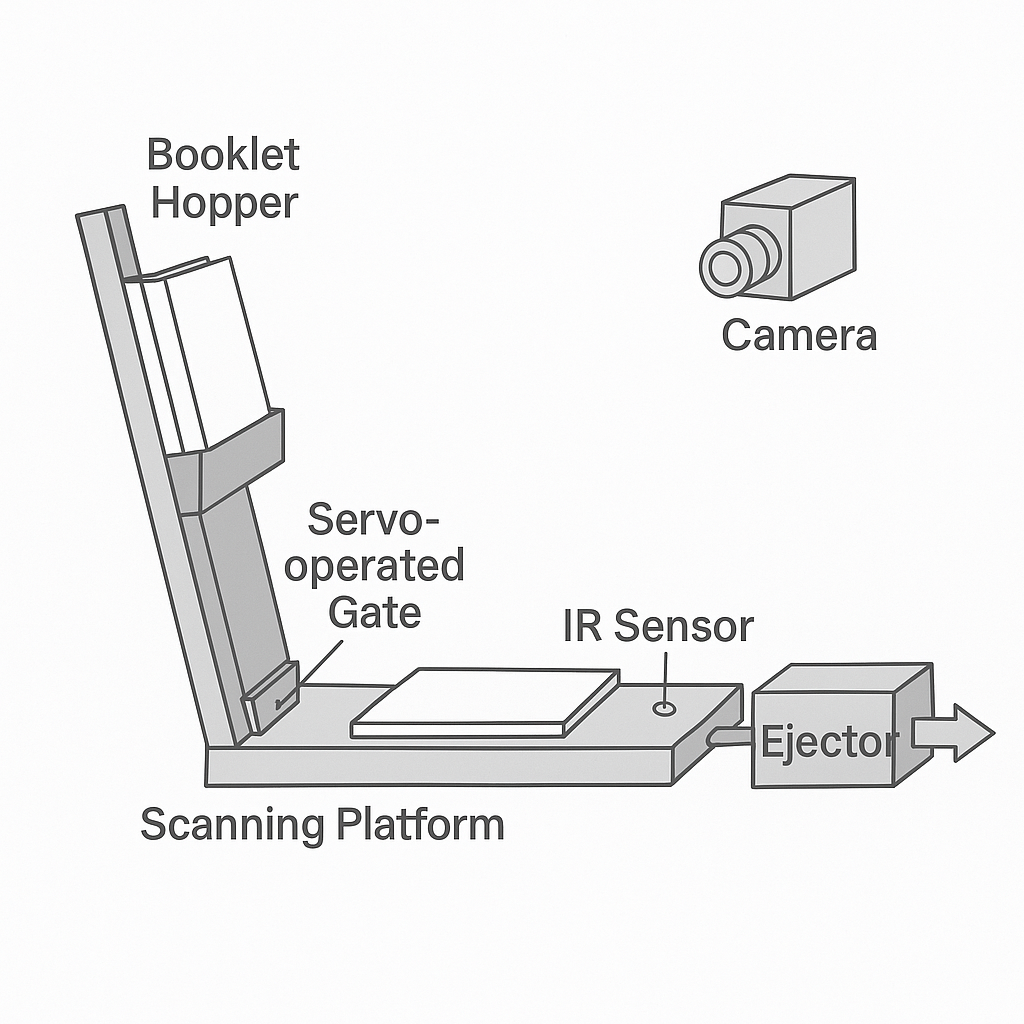

Generating caption...

--- Generated Caption ---
Fine-tuned Model Output: **a diagram of the sensor and sensor**
-------------------------


In [ ]:
from transformers import AutoProcessor, BlipForConditionalGeneration
from PIL import Image
from IPython.display import display
from google.colab import files
import torch
import io

MODEL_PATH = "./final_blip_captioner"
device = "cuda" if torch.cuda.is_available() else "cpu"

print(f"Loading fine-tuned BLIP model from {MODEL_PATH}...")
try:
    model = BlipForConditionalGeneration.from_pretrained(MODEL_PATH).to(device)
    processor = AutoProcessor.from_pretrained(MODEL_PATH)
    model.eval()
    print("Model loaded successfully.")

except Exception as e:
    print(f"ERROR: Failed to load model. Ensure Step 4 completed successfully and the directory exists. Error: {e}")
    raise

print("Image Upload")
print("Please upload the image you want the model to caption:")
uploaded = files.upload()

if not uploaded:
    print("No image uploaded. Skipping test.")
else:
    image_filename = next(iter(uploaded))
    image_data = uploaded[image_filename]

    try:
        sample_image = Image.open(io.BytesIO(image_data)).convert("RGB")
    except Exception as e:
        print(f"ERROR: Could not open uploaded file as an image. Error: {e}")
        sample_image = None

    if sample_image:
        print(f"Image '{image_filename}' uploaded successfully.")
        print("Model Test")
        display(sample_image)

        inputs = processor(images=sample_image, return_tensors="pt").to(device)
        pixel_values = inputs.pixel_values

        print("Generating caption...")
        generated_ids = model.generate(
            pixel_values=pixel_values,
            max_length=50,
            num_beams=4
        )

        generated_caption = processor.decode(generated_ids.squeeze(), skip_special_tokens=True)

        print("Generated Caption")
        print(f"Fine-tuned Model Output: {generated_caption}")

Loading Text-to-Image pipeline with model: runwayml/stable-diffusion-v1-5 on device: cuda...


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

Pipeline loaded successfully!

--- Generate Your Image ---
Enter your image description (e.g., 'A robot walking in a neon-lit rain'): a robot drinking cold drink on moon
Generating image for prompt: 'a robot drinking cold drink on moon'


  0%|          | 0/25 [00:00<?, ?it/s]


✅ Image Generated!


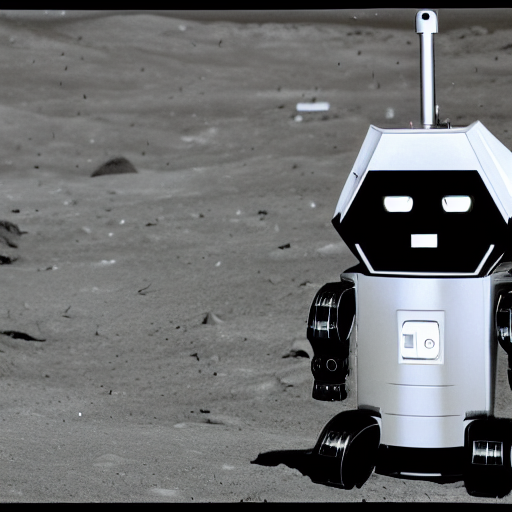

In [ ]:
from diffusers import AutoPipelineForText2Image, EulerDiscreteScheduler
import torch
from IPython.display import display

MODEL_NAME = "runwayml/stable-diffusion-v1-5"
device = "cuda" if torch.cuda.is_available() else "cpu"

print(f"Loading Text-to-Image pipeline with model: {MODEL_NAME} on device: {device}...")

try:
    pipe = AutoPipelineForText2Image.from_pretrained(
        MODEL_NAME,
        torch_dtype=torch.float16
    ).to(device)
    pipe.scheduler = EulerDiscreteScheduler.from_config(pipe.scheduler.config)
    print("Pipeline loaded successfully!")
except Exception as e:
    print(f"ERROR: Failed to load the model. Ensure you have a GPU runtime enabled. Error: {e}")
    if device == "cuda":
        print("Attempting to load on CPU with float32 as a fallback...")
        pipe = AutoPipelineForText2Image.from_pretrained(MODEL_NAME).to("cpu")
        pipe.scheduler = EulerDiscreteScheduler.from_config(pipe.scheduler.config)
        device = "cpu"
        print("Pipeline loaded on CPU (performance will be slow).")
    else:
        raise

print("\nGenerate Your Image")

user_prompt = input("Enter your image description : ")

if not user_prompt.strip():
    user_prompt = "A simple abstract painting"
    print(f"No input detected. Using default prompt: '{user_prompt}'")

print(f"Generating image for prompt: '{user_prompt}'")

image = pipe(
    prompt=user_prompt,
    num_inference_steps=25,
    guidance_scale=7.5
).images[0]

print("\nImage Generated!")
display(image)